In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy import stats
import psycopg2
from sqlalchemy import create_engine
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [179]:
class INSURANCE:
    
    def __init__(self, filepath):
        self.filepath = filepath            # Store the file path
        self.data = pd.read_csv(filepath)   # reads the file path

    """ BASIC INSPECTION """

    """ Displaying the dataframe """
    def data_frame(self):
        return self.data
    
    """ information of the insurance dataframe """
    def Information(self):
        return self.data.info()

    """ Total elements in dataframe """
    def total_elements(self):
        return self.data.size

    """ columns of the dataframe """
    def Columns(self):
        return self.data.columns

    """ size of the rows and columns """
    def Shape(self):
        return self.data.shape

    """ Datatypes of dataframe """
    def Dtypes(self):
        return self.data.dtypes

    """ DATA CLEANING """
        
    """ sum of null values by each column """
    def Sum_nullvalues(self):
        return self.data.isnull().sum()
        
    """ Filling the null values with 'Fire' """
    def Fillnull(self):
        return self.data.fillna('Fire',inplace = True)

    """ Detecting duplicates """
    def Duplicates(self):
        return self.data.apply(lambda x: x.duplicated())

    """ DATA TRANSFORMATION """
    
    """ Replacing ? in police_report_available to No """
    def Replacing(self,col):
        self.data[col] = self.data[col].replace('?', 'NO')
        return

    """ sorting the values by policy number """
    def Sortvalues(self,col):
        return self.data.sort_values(by = [col] , ascending = True)
        
    """ Finding the range among all numeric columns """
    def Range(self):
        return self.data.apply(lambda x: x.max() - x.min() if x.dtype != 'object' else None)

    """ Fraud reported per year """
    def Yearly_fraud_reported(self,col1,col2):
        fraud_per_year = self.data.groupby([col1,col2]).size().unstack(fill_value=0)
        return fraud_per_year

    """ Fraud reported by cities """
    def Fraud_reported_by_cities(self, col1, col2):
        fraud_by_state = self.data[self.data[col1] == 'Y'].groupby(col2).size().sort_values(ascending=False).reset_index()
        return fraud_by_state

    """ Max insurance claims by auto_make """
    def Max_claim(self,col1,col2):
        max_claim_by_company = self.data.groupby(col1)[col2].sum().sort_values(ascending=False).reset_index()
        return max_claim_by_company

    """ Age wise fraudreported """
    def Fraud_by_age(self,col1, col2):
        fraud_report = self.data[self.data[col1] == 'Y']
        age_fraud_counts = fraud_report[col2].value_counts().sort_index()
        return age_fraud_counts.reset_index()

    """ STATISTICAL ANALYSIS"""

    """ statistical information of the dataframe """
    def Stat_info(self):
        return self.data.describe()

    """ Measures """
    def Statistical_measures(self):
        numeric_cols = self.data.select_dtypes(include=['int64', 'float64']).columns
        measures = []
    
        for col in numeric_cols:
            measures.append({
            'Column': col,
            'Mean': self.data[col].mean(),
            'Median': self.data[col].median(),
            'Mode': self.data[col].mode()[0],
            'Variance': self.data[col].var(),
            'Std_Dev': self.data[col].std()
        })
    
        return pd.DataFrame(measures)

    """ correlation between two columns """
    def Corr_coef(self,col1,col2):
        return np.corrcoef(self.data[col1],self.data[col2])[0][1]

    """ correlation among all the numeric columns with target"""
    # correlation among the columns with total_claim_amount column
    # integer columns
    def Correlation(self):
        continious_var = self.data.select_dtypes(include=['int64','float64']).columns.tolist()
        correlated = []
        target = 'total_claim_amount'

        for col in continious_var:
            if col != target:  #  comparing all continious variable columns  with target
                result = np.corrcoef(self.data[col], self.data[target])[0][1]
                if abs(result) :
                    correlated.append((col, target, round(result, 3)))
            
        # Print results
        for pair in correlated:
            print(f"{pair[0]} vs {pair[1]}  => correlation: {pair[2]}")

        return 

    """ Anova among all the categorical variables with target """
    # Anova 
    # categorical columns
    def Anova(self):
        target = 'total_claim_amount'
    
        # Select categorical columns
        categorical_var = self.data.select_dtypes(include=['object']).columns
    
        for col in categorical_var:
            groups = [group[target].values for name, group in self.data.groupby(col)]
        
            # Filter out empty or single-value groups
            groups = [g for g in groups if len(g) > 1]
        
            if len(groups) >= 2:  # At least 2 valid groups
                f_stat, p_val = stats.f_oneway(*groups)
                print(f"ANOVA for {col}: F = {f_stat:.3f}, p = {p_val:.3e}")
            else:
                print(f"Skipping {col}: Not enough data for ANOVA")
        return


    """ chi-square test for all category columns with target column"""
    def Chi_square(self):
        target = 'fraud_reported'
    
        categorical_vars = self.data.select_dtypes(include=['object', 'category']).columns.tolist()
        results = []
    
        for col in categorical_vars:
            if col == target:
                continue
        
            table = pd.crosstab(self.data[col], self.data[target])
        
            if table.shape[0] > 1 and table.shape[1] > 1:
                chi2, p, dof, expected = chi2_contingency(table)
                interpretation = 'Significant' if p < 0.05 else 'Not Significant'
            
                results.append({
                'Variable': col,
                'Chi2': round(chi2, 3),
                'p-Value': format(p, '.3e'),
                'DF': dof,
                'Interpretation': interpretation
                })
    
        return pd.DataFrame(results).sort_values(by='p-Value').reset_index(drop=True)

    """ calculating outliers """
    def Outliers(self, col):
        Q1 = self.data[col].quantile(0.25)
        Q3 = self.data[col].quantile(0.75)
        IQR = Q3 - Q1 # inter quartile range
    
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
    
        outliers = self.data[(self.data[col] < lower_bound) | (self.data[col] > upper_bound)]
        print(f"Lower Bound: {lower_bound}")
        print(f"Upper Bound: {upper_bound}")
        print(f"Number of outliers: {len(outliers)}")
        return
    


    """ VISUALIZATIONS """
    
    """ Barplot """
    def Bar_plot(self, col1, col2):
        plt.figure(figsize=(14, 6))
        sns.countplot(data=self.data, x=col2, hue=col1, palette="coolwarm",
                  order=self.data[col2].value_counts().index)
        plt.title(f"{col1} by {col2}")
        plt.xlabel(col2)
        plt.ylabel("Count")
        plt.xticks()
        plt.legend(title=col1)
        plt.show()

    """ Heat map for finding correlation """
    def Heat_map(self,col1, col2, col3):
        plt.figure(figsize=(15,10))
        sns.heatmap(self.data[[col1, col2, col3]].corr(), annot=True, cmap='YlGnBu')
        plt.title("Correlation among injury_claim, property_claim, vehicle claim")
        plt.show()

    """ Box plot for multiple columns """
    def Box_plot(self, columns):
        plt.figure(figsize=(12,8))
        sns.boxplot(data=self.data[columns], palette="Set2")
        plt.title("Box Plot of Insurance Claims")
        plt.xlabel("Claim Type")
        plt.ylabel("Claim Amount")
        plt.show()
        
    """ violin plot for policy deductible by policy state """
    def violin_plot(self, col1, col2):
        plt.figure(figsize=(12,8))
        sns.violinplot(data=self.data, x= col1, y= col2, palette="Set3")
        plt.title(f"Distribution of {col2} by {col1}")
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.xticks()
        plt.show()


    """ Scatter plot of Customer Age vs Claims """   
    def Scatter_plot(self,col1,col2):
        plt.figure(figsize=(12,8))
        sns.scatterplot(data=self.data, x= col1, y= col2, hue= col2 , palette="viridis")
        plt.title(f"Scatter Plot of {col2} vs {col1}")
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.xticks()
        plt.show()

    """ 3D scatter plot of insurance claims """
    def Surface_plot(self, col1, col2, col3):
        plt = px.scatter_3d(
            self.data,
            x= col1,
            y= col2,
            z= col3,
            color= col2,
            size_max=10,
            opacity=0.8,
            title='3D Scatter Plot of Insurance Claims',
            labels={
                'injury_claim': 'Injury Claim',
                'property_claim': 'Property Claim',
                'vehicle_claim': 'Vehicle Claim'}
        )
        plt.show()

    """ pie plot for auto_make and it's percentage """
    def Pie(self,col):
        vehicle_counts = self.data[col].value_counts()
        vehicle_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, shadow=True)
        plt.title("Vehicle Types")
        plt.ylabel("")
        plt.show()

    """ Histogram distribution by auto_model"""
    def Histogram(self,col):
        plt.figure(figsize=(15,10))
        sns.histplot(data=self.data, x=col, bins=20, color="skyblue")
        plt.title("Histogram distribution of auto_model")
        plt.xlabel(col)
        return plt.show()

    """ scaling """
    def std_scale(self):
        numeric = self.data.select_dtypes(exclude = 'object')
        scaler = StandardScaler()
        scaled = scaler.fit_transform(numeric)
        scaled_df = pd.DataFrame(scaled, columns=numeric.columns)
        return scaled_df

    def minmax_scale(self):
        numeric = self.data.select_dtypes(exclude = 'object')
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(numeric)
        scaled_df = pd.DataFrame(scaled, columns=numeric.columns)
        return scaled_df


    """ Connecting python to postgresql """
    """ ------------------ POSTGRESQL INTEGRATION ------------------ """
    @staticmethod
    def infer_sql_type(dtype):
        if pd.api.types.is_integer_dtype(dtype):
            return "INT"
        elif pd.api.types.is_float_dtype(dtype):
            return "FLOAT"
        elif pd.api.types.is_bool_dtype(dtype):
            return "BOOLEAN"
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            return "TIMESTAMP"
        else:
            return "TEXT"
            
            
    """ Generates SQL CREATE TABLE statement based on DataFrame column dtypes"""
    def generate_create_table_statement(self, table_name="insurance_data"):
        """  SQL CREATE TABLE statement """
        columns = self.data.dtypes
        sql_columns = ",\n    ".join([f'"{col}" {self.infer_sql_type(dtype)}' for col, dtype in columns.items()])
        create_stmt = f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
        {sql_columns}
        );
        """
        return create_stmt


    def save_to_postgres(self, conn_params, table_name="insurance_data"):
        """
        Creates table and inserts DataFrame records into PostgreSQL.
        Name of the PostgreSQL table "insurance_data".
        """
        create_stmt = self.generate_create_table_statement(table_name)

        try:
            conn = psycopg2.connect(**conn_params)
            cur = conn.cursor()
            
            # Create the table
            cur.execute(create_stmt)
            conn.commit()
            
            # Prepare insert statement
            columns = list(self.data.columns)
            placeholders = ', '.join(['%s'] * len(columns))
            insert_stmt = f"""
            INSERT INTO {table_name} ({', '.join(['"{}"'.format(col) for col in columns])})
            VALUES ({placeholders})
            """
            # Insert data row by row
            for _, row in self.data.iterrows():
                cur.execute(insert_stmt, tuple(row))
            conn.commit()
            
            cur.close()
            conn.close()
            print(f"Data inserted successfully into table {table_name}")
            
        except Exception as e:
            print(f"Error during PostgreSQL operation: {e}")

                    
    """ Reads data from a PostgreSQL table and returns a Pandas DataFrame """
    def read_from_postgresql(self, conn_params=None, table_name="insurance_data"):
        
        if conn_params is None:
            conn_params = {
                'dbname': "postgres",
                'user': "postgres",
                'password': "postgres",
                'host': "localhost",
                'port': "5432"
            }

        try:
            conn = psycopg2.connect(**conn_params)
            query = f'SELECT * FROM {table_name}'
            df = pd.read_sql(query, conn)
            conn.close()
            return df
        except Exception as e:
            print(f" Error reading from PostgreSQL: {e}")
            return None


    

In [180]:
#creating objects
obj = INSURANCE("insurance_claims.csv")

In [181]:
# retriving the dataframe
obj.data_frame()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,06-09-2000,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,06-06-2014,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,16-07-1991,OH,500/1000,1000,1310.80,0,431289,...,1,?,87200,17440,8720,61040,Honda,Accord,2006,N
996,285,41,186934,05-01-2014,IL,100/300,1000,1436.79,0,608177,...,3,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N
997,130,34,918516,17-02-2003,OH,250/500,500,1383.49,3000000,442797,...,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N
998,458,62,533940,18-11-2011,IL,500/1000,2000,1356.92,5000000,441714,...,1,YES,46980,5220,5220,36540,Audi,A5,1998,N


In [182]:
# dataframe information
obj.Information()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

In [183]:
# total elements in a dataframe
obj.total_elements()

39000

In [184]:
# sorting values
obj.Sortvalues("policy_number")

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
663,172,33,100804,24-02-2012,IL,100/300,1000,1459.96,6000000,600127,...,1,NO,41690,7580,7580,26530,Saab,95,1999,N
863,91,26,101421,19-10-1999,IL,250/500,1000,1022.46,0,444896,...,2,?,74200,7420,7420,59360,Jeep,Wrangler,1996,N
5,256,39,104594,12-10-2006,OH,250/500,1000,1351.10,0,478456,...,2,NO,64100,6410,6410,51280,Saab,95,2003,Y
589,75,25,106186,02-12-2011,IL,500/1000,1000,1389.86,0,472475,...,3,YES,65100,6510,6510,52080,Saab,93,2011,N
337,159,37,106873,28-08-1998,IL,500/1000,1000,894.40,0,446435,...,0,NO,70290,7810,7810,54670,Dodge,RAM,1999,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,116,30,996253,29-11-2001,IN,500/1000,500,951.46,0,467227,...,3,?,59670,6630,6630,46410,Volkswagen,Passat,2004,Y
605,246,44,996850,08-03-1995,OH,100/300,1000,1397.00,0,614521,...,0,NO,61740,6860,6860,48020,Accura,MDX,1997,N
558,210,35,998192,25-04-2014,IL,100/300,500,1433.24,0,476203,...,1,?,24570,2730,2730,19110,Saab,95,2006,Y
673,80,28,998865,05-12-2014,IL,500/1000,1000,1740.57,0,442142,...,1,?,33480,3720,3720,26040,Dodge,Neon,2011,N


In [185]:
# columns in dataframe
obj.Columns()

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported'],
      dtype='object')

In [186]:
# rows and columns size
obj.Shape()

(1000, 39)

In [187]:
# datatypes 
obj.Dtypes()

months_as_customer               int64
age                              int64
policy_number                    int64
policy_bind_date                object
policy_state                    object
policy_csl                      object
policy_deductable                int64
policy_annual_premium          float64
umbrella_limit                   int64
insured_zip                      int64
insured_sex                     object
insured_education_level         object
insured_occupation              object
insured_hobbies                 object
insured_relationship            object
capital-gains                    int64
capital-loss                     int64
incident_date                   object
incident_type                   object
collision_type                  object
incident_severity               object
authorities_contacted           object
incident_state                  object
incident_city                   object
incident_location               object
incident_hour_of_the_day 

In [188]:
# nulls count
obj.Sum_nullvalues()

months_as_customer              0
age                             0
policy_number                   0
policy_bind_date                0
policy_state                    0
policy_csl                      0
policy_deductable               0
policy_annual_premium           0
umbrella_limit                  0
insured_zip                     0
insured_sex                     0
insured_education_level         0
insured_occupation              0
insured_hobbies                 0
insured_relationship            0
capital-gains                   0
capital-loss                    0
incident_date                   0
incident_type                   0
collision_type                  0
incident_severity               0
authorities_contacted          91
incident_state                  0
incident_city                   0
incident_location               0
incident_hour_of_the_day        0
number_of_vehicles_involved     0
property_damage                 0
bodily_injuries                 0
witnesses     

In [189]:
# filling null values
obj.Fillnull()

In [190]:
# checking for duplicates
obj.Duplicates()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,True,False,True,False,True,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,True,True,False,False,False,...,True,True,False,False,False,False,False,False,False,True
4,True,False,False,False,True,False,True,False,True,False,...,False,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,True,True,False,False,True,True,True,False,True,False,...,True,True,False,False,False,False,True,True,True,True
996,True,True,False,False,True,True,True,False,True,False,...,True,True,False,False,False,True,True,True,True,True
997,True,True,False,False,True,True,True,False,True,False,...,True,True,False,False,False,False,True,True,True,True
998,True,True,False,False,True,True,True,False,True,False,...,True,True,True,True,True,True,True,True,True,True


In [191]:
#replacing data
obj.Replacing("police_report_available")

In [192]:
# max-min 
obj.Range()

months_as_customer                  479.00
age                                  45.00
policy_number                    898631.00
policy_bind_date                       NaN
policy_state                           NaN
policy_csl                             NaN
policy_deductable                  1500.00
policy_annual_premium              1614.26
umbrella_limit                 11000000.00
insured_zip                      190858.00
insured_sex                            NaN
insured_education_level                NaN
insured_occupation                     NaN
insured_hobbies                        NaN
insured_relationship                   NaN
capital-gains                    100500.00
capital-loss                     111100.00
incident_date                          NaN
incident_type                          NaN
collision_type                         NaN
incident_severity                      NaN
authorities_contacted                  NaN
incident_state                         NaN
incident_ci

In [193]:
#fraud reported by every year
obj.Yearly_fraud_reported('auto_year', 'fraud_reported')

fraud_reported,N,Y
auto_year,,
1995,43,13
1996,23,14
1997,34,12
1998,33,7
1999,45,10
2000,31,11
2001,33,9
2002,39,10
2003,42,9


In [194]:
# fraud reported by state
obj.Fraud_reported_by_cities("fraud_reported","policy_state")

,policy_state,0
0,OH,91
1,IN,79
2,IL,77


In [195]:
# tatal claim amount by automake
obj.Max_claim("auto_make","total_claim_amount")

,auto_make,total_claim_amount
0,Dodge,4475550
1,Suburu,4298410
2,Saab,4115630
3,Ford,4073050
4,BMW,4025180
5,Nissan,4020530
6,Chevrolet,4008740
7,Audi,3752480
8,Accura,3571280
9,Volkswagen,3458130


In [196]:
# fraud reported by age
obj.Fraud_by_age("fraud_reported","age")

,age,count
0,19,1
1,22,1
2,23,4
3,24,2
4,25,4
5,26,8
6,27,3
7,28,7
8,29,10
9,30,6


# STATISTICAL ANALYSIS


In [197]:
# statistical info
obj.Stat_info()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000


In [198]:
# measures
obj.Statistical_measures()

,Column,Mean,Median,Mode,Variance,Std_Dev
0,months_as_customer,2.039540e+02,199.5,194.00,1.325104e+04,1.151132e+02
1,age,3.894800e+01,38.0,43.00,8.354484e+01,9.140287e+00
2,policy_number,5.462386e+05,533135.0,100804.00,6.608139e+10,2.570630e+05
3,policy_deductable,1.136000e+03,1000.0,1000.00,3.743784e+05,6.118647e+02
4,policy_annual_premium,1.256406e+03,1257.2,1073.83,5.961772e+04,2.441674e+02
5,umbrella_limit,1.101000e+06,0.0,0.00,5.278077e+12,2.297407e+06
6,insured_zip,5.012145e+05,466445.5,431202.00,5.141121e+09,7.170161e+04
7,capital-gains,2.512610e+04,0.0,0.00,7.768588e+08,2.787219e+04
8,capital-loss,-2.679370e+04,-23250.0,0.00,7.898403e+08,2.810410e+04
9,incident_hour_of_the_day,1.164400e+01,12.0,17.00,4.832159e+01,6.951373e+00


In [199]:
# correlation coefficient 
obj.Corr_coef("policy_annual_premium","umbrella_limit")

np.float64(-0.0062468030298138055)

In [200]:
#coorelation
obj.Correlation()

months_as_customer vs total_claim_amount  => correlation: 0.062
age vs total_claim_amount  => correlation: 0.07
policy_number vs total_claim_amount  => correlation: -0.018
policy_deductable vs total_claim_amount  => correlation: 0.023
policy_annual_premium vs total_claim_amount  => correlation: 0.009
umbrella_limit vs total_claim_amount  => correlation: -0.04
insured_zip vs total_claim_amount  => correlation: -0.034
capital-gains vs total_claim_amount  => correlation: 0.016
capital-loss vs total_claim_amount  => correlation: -0.036
incident_hour_of_the_day vs total_claim_amount  => correlation: 0.218
number_of_vehicles_involved vs total_claim_amount  => correlation: 0.274
bodily_injuries vs total_claim_amount  => correlation: 0.047
witnesses vs total_claim_amount  => correlation: -0.011
injury_claim vs total_claim_amount  => correlation: 0.805
property_claim vs total_claim_amount  => correlation: 0.811
vehicle_claim vs total_claim_amount  => correlation: 0.983
auto_year vs total_claim_

In [201]:
# calulating Anova
obj.Anova()

ANOVA for policy_bind_date: F = 1.269, p = 2.071e-01
ANOVA for policy_state: F = 0.037, p = 9.638e-01
ANOVA for policy_csl: F = 2.456, p = 8.626e-02
ANOVA for insured_sex: F = 0.562, p = 4.536e-01
ANOVA for insured_education_level: F = 1.144, p = 3.346e-01
ANOVA for insured_occupation: F = 1.309, p = 2.009e-01
ANOVA for insured_hobbies: F = 0.877, p = 6.123e-01
ANOVA for insured_relationship: F = 0.152, p = 9.796e-01
ANOVA for incident_date: F = 1.248, p = 1.038e-01
ANOVA for incident_type: F = 772.255, p = 2.524e-259
ANOVA for collision_type: F = 769.989, p = 7.019e-259
ANOVA for incident_severity: F = 208.128, p = 8.681e-105
ANOVA for authorities_contacted: F = 36.749, p = 1.582e-22
ANOVA for incident_state: F = 2.011, p = 6.154e-02
ANOVA for incident_city: F = 1.003, p = 4.216e-01
Skipping incident_location: Not enough data for ANOVA
ANOVA for property_damage: F = 1.917, p = 1.477e-01
ANOVA for police_report_available: F = 1.301, p = 2.543e-01
ANOVA for auto_make: F = 0.683, p = 7.8

In [202]:
# calculating chi-square
obj.Chi_square()

,Variable,Chi2,p-Value,DF,Interpretation
0,incident_state,16.129,1.308e-02,6,Significant
1,auto_model,46.658,1.583e-01,38,Not Significant
2,insured_occupation,17.659,1.709e-01,13,Not Significant
3,property_damage,8.031,1.803e-02,2,Significant
4,incident_type,29.132,2.101e-06,3,Significant
5,policy_bind_date,969.533,3.226e-01,950,Not Significant
6,policy_csl,2.137,3.435e-01,2,Not Significant
7,incident_date,62.748,3.449e-01,59,Not Significant
8,insured_sex,0.815,3.667e-01,1,Not Significant
9,insured_relationship,5.389,3.702e-01,5,Not Significant


In [203]:
# detect outliers
obj.Outliers("total_claim_amount")

Lower Bound: -1357.5
Upper Bound: 113762.5
Number of outliers: 1


# VISUALIZATIONS

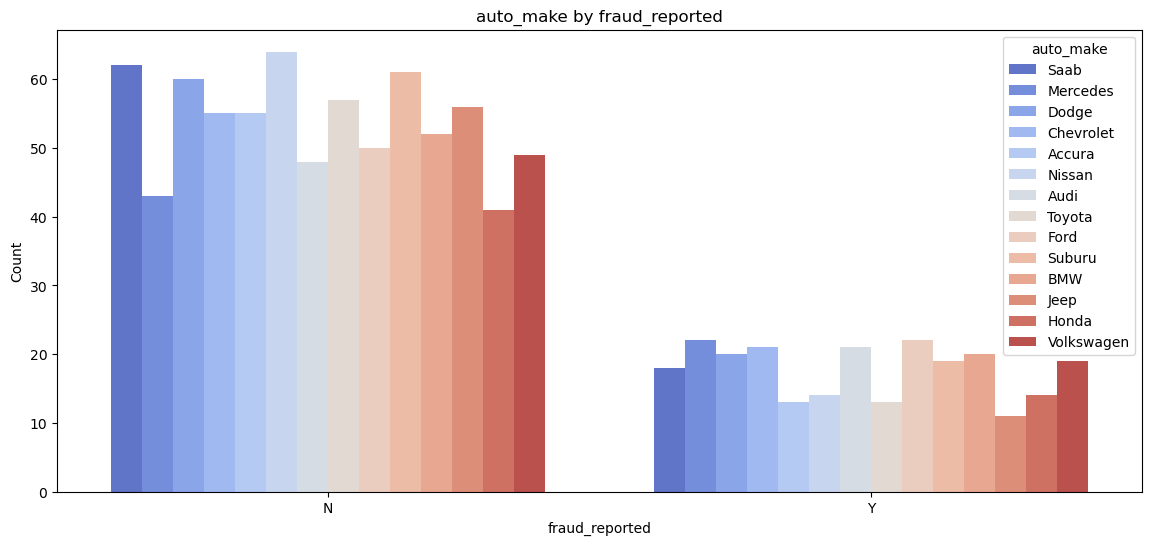

In [204]:
# barplot
obj.Bar_plot("auto_make", "fraud_reported")

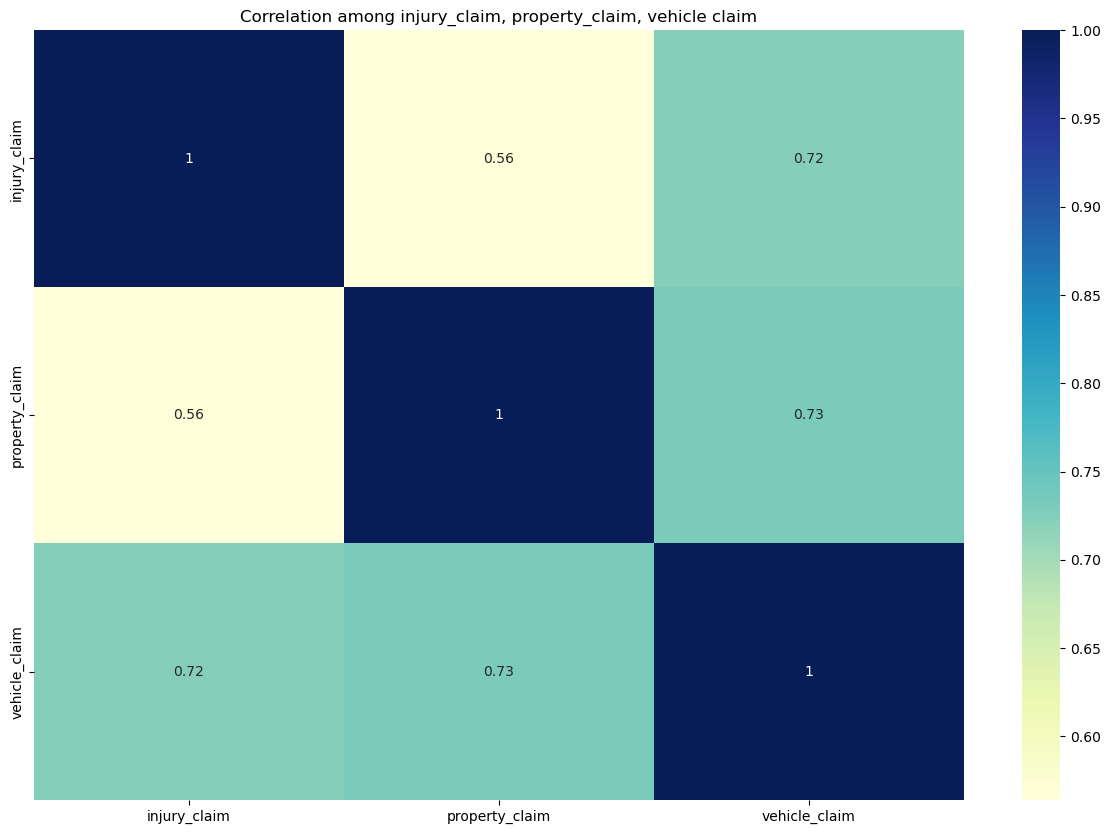

In [205]:
# heatmap
obj.Heat_map("injury_claim", "property_claim", "vehicle_claim")

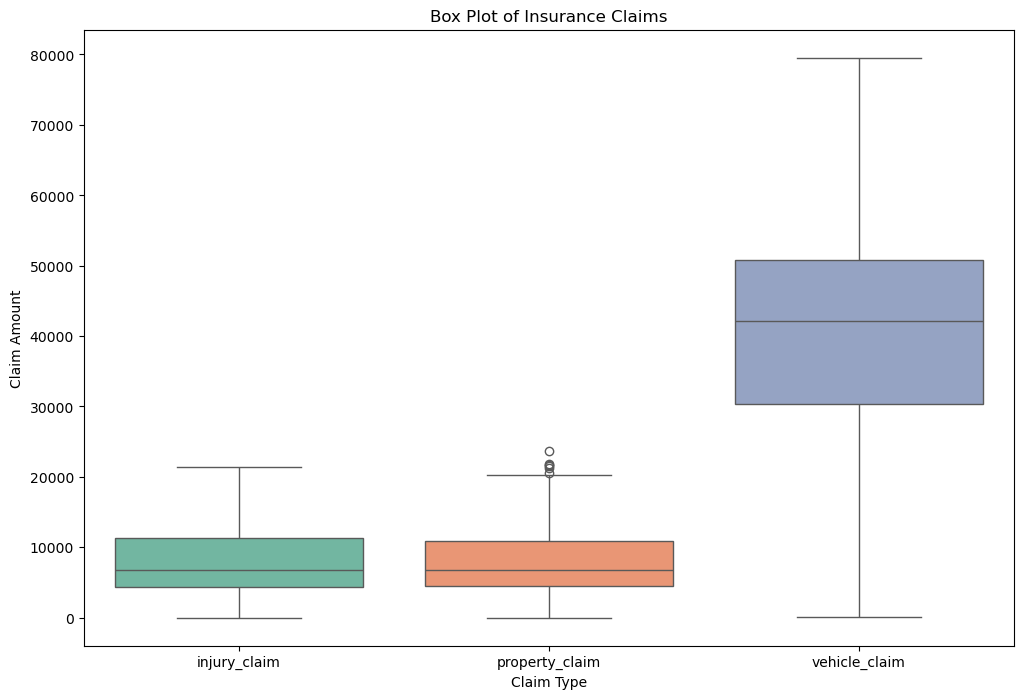

In [206]:
#boxplot
columns = ['injury_claim', 'property_claim', 'vehicle_claim']
obj.Box_plot(columns)


C:\Users\rosan\AppData\Local\Temp\ipykernel_204\51675687.py:230: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




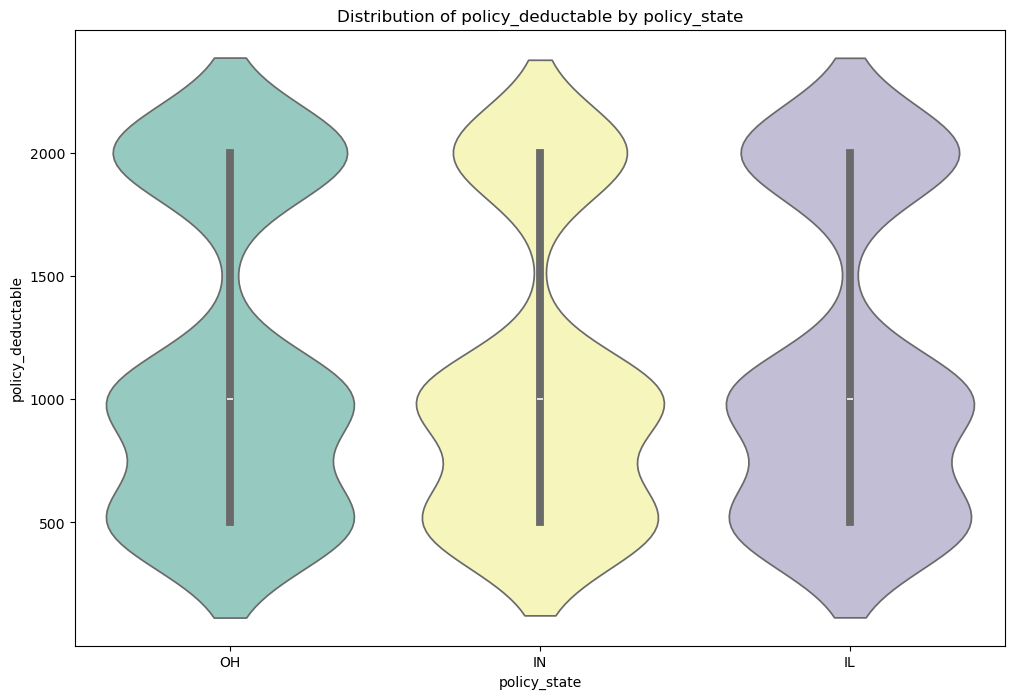

In [207]:
# violin plot
obj.violin_plot("policy_state", "policy_deductable")

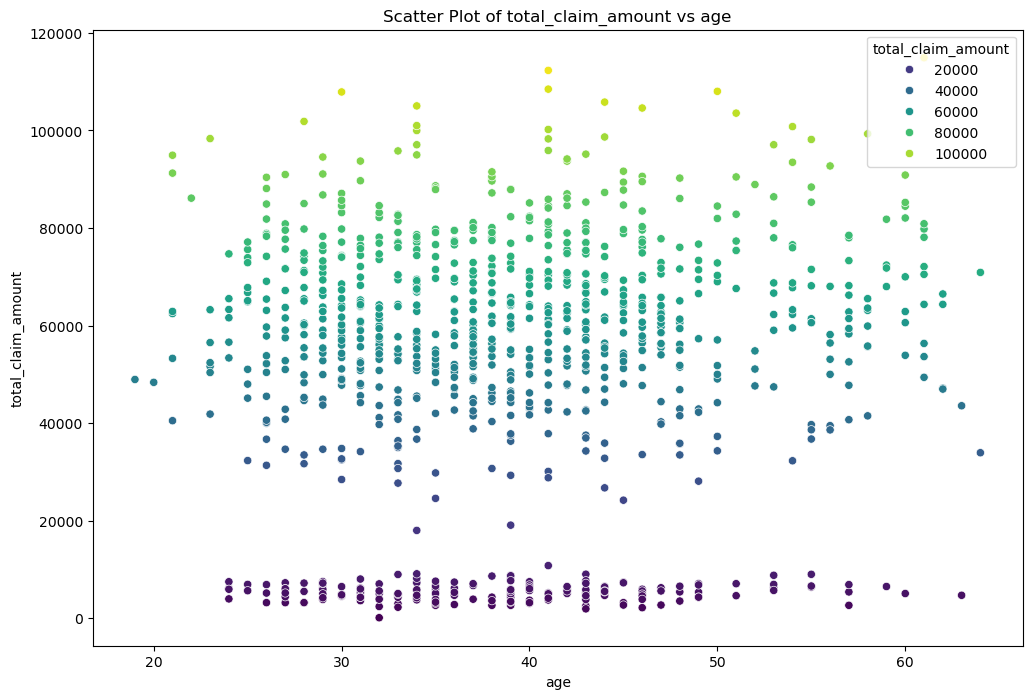

In [208]:
# scatterplot
obj.Scatter_plot("age", "total_claim_amount")

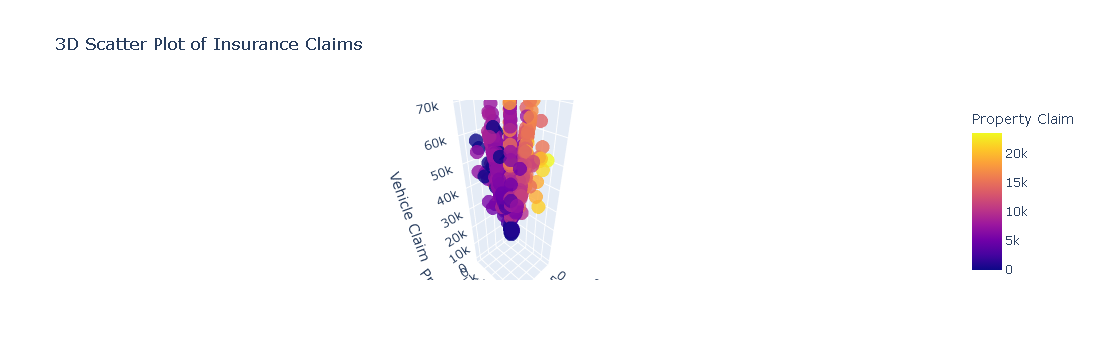

In [209]:
#surface plot
obj.Surface_plot('injury_claim', 'property_claim', 'vehicle_claim')

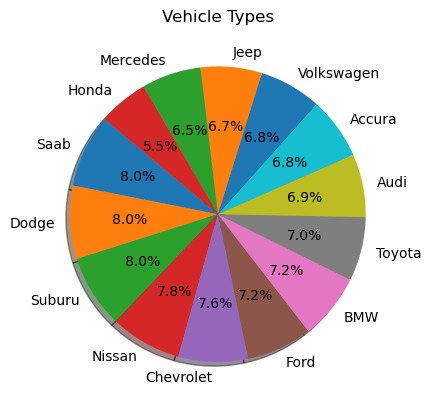

In [210]:
#pie chart
obj.Pie("auto_make")

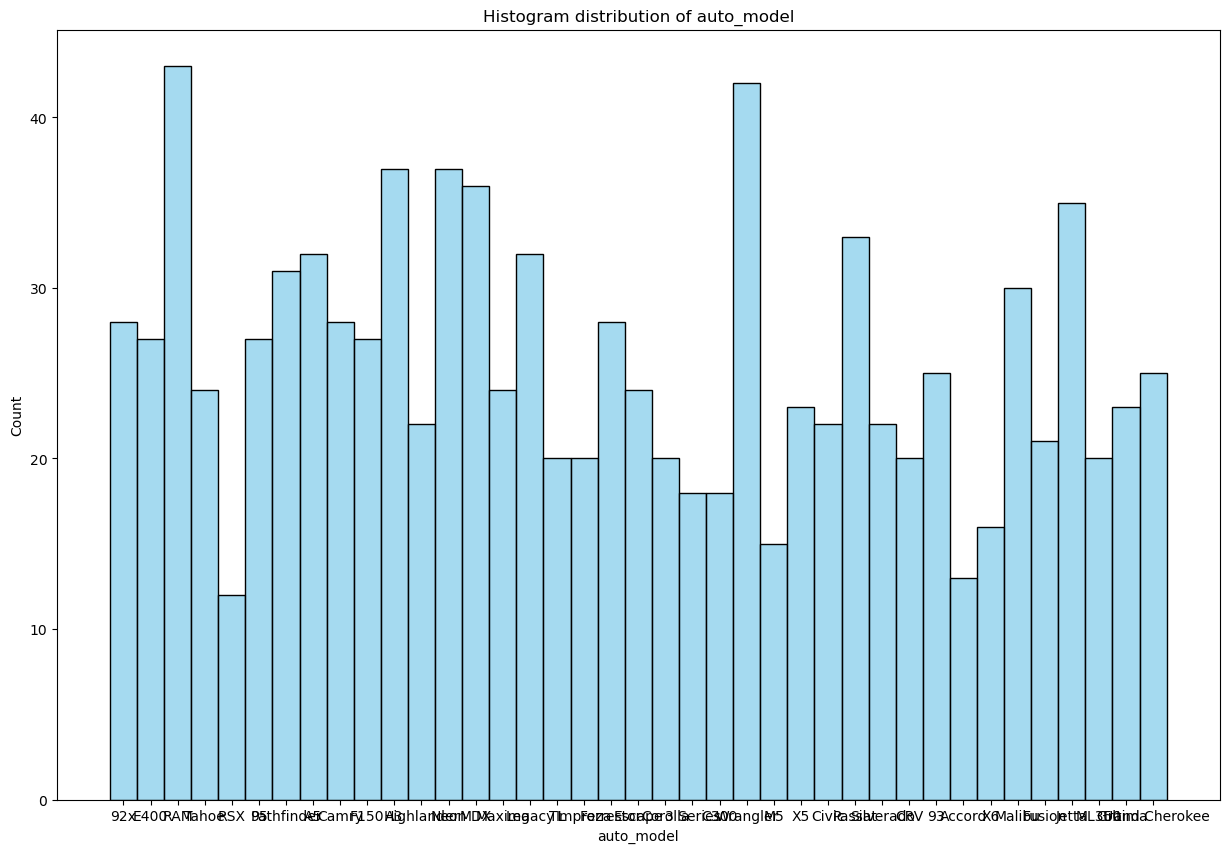

In [211]:
# Histogram
obj.Histogram("auto_model")

In [212]:
obj.std_scale()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
0,1.078140,0.990836,-0.095953,-0.222383,0.616705,-0.479476,-0.489529,1.011331,0.953851,-0.956261,-0.823865,0.009759,0.461838,0.714257,-0.189283,1.165505,0.749653,-0.183440
1,0.208995,0.334073,-0.791527,1.412784,-0.242521,1.697980,-0.461008,-0.901927,0.953851,-0.524475,-0.823865,-1.210174,-1.338700,-1.807312,-1.363822,-1.372696,-1.823346,0.315491
2,-0.608002,-1.088913,0.550566,1.412784,0.642233,1.697980,-0.984885,0.358023,0.953851,-0.668404,1.140056,1.229693,1.362107,-0.686362,0.054644,-0.736072,-0.785565,0.315491
3,0.452355,0.224613,-1.239334,1.412784,0.652886,2.133471,1.491682,0.853388,-1.267577,-0.956261,-0.823865,0.009759,0.461838,0.403135,-0.224130,-0.219722,0.677607,1.479664
4,0.208995,0.552994,-0.695834,-0.222383,1.341980,2.133471,1.527808,1.467210,-0.683741,1.202666,-0.823865,-1.210174,-0.438431,-1.753121,-1.257232,-1.399654,-1.768252,0.648112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.746582,-0.103769,1.539740,-0.222383,0.222884,-0.479476,-0.975717,-0.901927,0.953851,1.202666,-0.823865,-1.210174,-0.438431,1.305049,2.051155,0.273817,1.224309,0.149180
996,0.704407,0.224613,-1.398429,-0.222383,0.739141,-0.479476,1.492519,1.643100,0.953851,1.634452,-0.823865,1.229693,1.362107,2.111466,2.182342,2.214794,1.821868,1.645974
997,-0.642767,-0.541611,1.448920,-1.039966,0.520739,0.826998,-0.815138,0.358023,0.953851,-1.100189,1.140056,1.229693,1.362107,0.558507,0.013648,0.020826,0.771902,-1.513924
998,2.208028,2.523284,-0.047867,1.412784,0.411866,1.697980,-0.830250,-0.901927,0.953851,-1.388046,-0.823865,-1.210174,-0.438431,-0.219110,-0.453708,-0.451976,-0.073580,-1.181303


In [213]:
obj.minmax_scale()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
0,0.684760,0.644444,0.468247,0.333333,0.603112,0.090909,0.188769,0.530348,1.000000,0.217391,0.000000,0.5,0.666667,0.622801,0.303497,0.550063,0.654296,0.45
1,0.475992,0.511111,0.269370,1.000000,0.473214,0.545455,0.199478,0.000000,1.000000,0.347826,0.000000,0.0,0.000000,0.043285,0.036364,0.032953,0.043276,0.60
2,0.279749,0.222222,0.653098,1.000000,0.606972,0.545455,0.002766,0.349254,1.000000,0.304348,0.666667,1.0,1.000000,0.300906,0.358974,0.162653,0.289722,0.60
3,0.534447,0.488889,0.141334,1.000000,0.608582,0.636364,0.932699,0.486567,0.438344,0.217391,0.000000,0.5,0.666667,0.551298,0.295571,0.267850,0.637187,0.95
4,0.475992,0.555556,0.296730,0.333333,0.712760,0.636364,0.946264,0.656716,0.585959,0.869565,0.000000,0.0,0.333333,0.055739,0.060606,0.027461,0.056359,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.006263,0.422222,0.935920,0.333333,0.543574,0.090909,0.006209,0.000000,1.000000,0.869565,0.000000,0.0,0.333333,0.758579,0.813054,0.368399,0.767015,0.55
996,0.594990,0.488889,0.095846,0.333333,0.621622,0.090909,0.933013,0.705473,1.000000,1.000000,0.000000,1.0,1.000000,0.943912,0.842890,0.763836,0.908919,1.00
997,0.271399,0.333333,0.909953,0.000000,0.588604,0.363636,0.066505,0.349254,1.000000,0.173913,0.666667,1.0,1.000000,0.587006,0.349650,0.316857,0.659580,0.05
998,0.956159,0.955556,0.481995,1.000000,0.572145,0.545455,0.060831,0.000000,1.000000,0.086957,0.000000,0.0,0.333333,0.408291,0.243357,0.220532,0.458800,0.15


# Connecting python to postgresql

In [35]:
print(obj.generate_create_table_statement())


        CREATE TABLE IF NOT EXISTS insurance_data (
        "months_as_customer" INT,
    "age" INT,
    "policy_number" INT,
    "policy_bind_date" TEXT,
    "policy_state" TEXT,
    "policy_csl" TEXT,
    "policy_deductable" INT,
    "policy_annual_premium" FLOAT,
    "umbrella_limit" INT,
    "insured_zip" INT,
    "insured_sex" TEXT,
    "insured_education_level" TEXT,
    "insured_occupation" TEXT,
    "insured_hobbies" TEXT,
    "insured_relationship" TEXT,
    "capital-gains" INT,
    "capital-loss" INT,
    "incident_date" TEXT,
    "incident_type" TEXT,
    "collision_type" TEXT,
    "incident_severity" TEXT,
    "authorities_contacted" TEXT,
    "incident_state" TEXT,
    "incident_city" TEXT,
    "incident_location" TEXT,
    "incident_hour_of_the_day" INT,
    "number_of_vehicles_involved" INT,
    "property_damage" TEXT,
    "bodily_injuries" INT,
    "witnesses" INT,
    "police_report_available" TEXT,
    "total_claim_amount" INT,
    "injury_claim" INT,
    "property_c

In [36]:
# Inserting data into postgresql database
conn_params = {
    'dbname': "postgres",
    'user': "postgres",
    'password': "postgres",
    'host': "localhost",
    'port': "5432"
}
obj.save_to_postgres(conn_params, table_name="insurance_data")

Data inserted successfully into table insurance_data


# Connecting postgresql to python


In [37]:
# Reading the data from postgresql to python
conn_params = {
    'dbname': "postgres",
    'user': "postgres",
    'password': "postgres",
    'host': "localhost",
    'port': "5432"
}
obj.read_from_postgresql(conn_params, "insurance_data")


C:\Users\rosan\AppData\Local\Temp\ipykernel_4824\2564964684.py:362: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,old vs young
0,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,young age
1,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,young age
2,134,29,687698,06-09-2000,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,young age
3,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,young age
4,228,44,367455,06-06-2014,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,young age
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,3,38,941851,16-07-1991,OH,500/1000,1000,1310.80,0,431289,...,NO,87200,17440,8720,61040,Honda,Accord,2006,N,None
8996,285,41,186934,05-01-2014,IL,100/300,1000,1436.79,0,608177,...,NO,108480,18080,18080,72320,Volkswagen,Passat,2015,N,None
8997,130,34,918516,17-02-2003,OH,250/500,500,1383.49,3000000,442797,...,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N,None
8998,458,62,533940,18-11-2011,IL,500/1000,2000,1356.92,5000000,441714,...,YES,46980,5220,5220,36540,Audi,A5,1998,N,None
